In [3]:
import matplotlib.pyplot as plt
from datetime import datetime
import folium
import numpy as np
import matplotlib as mpl
from folium.plugins import MarkerCluster
import json
import fiona 
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.ticker as ticker
import pandas as pd
from plotly import graph_objs as go
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [4]:
sns.set_theme()

# Entrance Analysis

In [4]:
#import WAZE data
df=pd.read_csv('MORA_park_region_results_clean_20210817.csv', encoding="ISO-8859-1")

In [75]:
df.head()

,Unnamed: 0,NAME,UNIT_TYPE,Time,Alert,Sub_Alert,Street,State,Lon,Lat,Type
0,1,MORA,National Park,2017-03-05 12:54:05,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.539917,46.866887,in-park
1,2,MORA,National Park,2017-03-05 12:54:06,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.520425,46.869337,in-park
2,3,MORA,National Park,2017-03-05 12:53:46,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-123,WA,-121.519142,46.830834,in-park
3,4,MORA,National Park,2017-03-05 12:54:33,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-123,WA,-121.554361,46.785824,in-park
4,5,MORA,National Park,2017-03-05 12:53:40,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-123,WA,-121.554361,46.785824,in-park


In [5]:
df.rename( columns={'Unnamed: 0':'Id'}, inplace=True )

In [77]:
df.head()

,Id,NAME,UNIT_TYPE,Time,Alert,Sub_Alert,Street,State,Lon,Lat,Type
0,1,MORA,National Park,2017-03-05 12:54:05,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.539917,46.866887,in-park
1,2,MORA,National Park,2017-03-05 12:54:06,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.520425,46.869337,in-park
2,3,MORA,National Park,2017-03-05 12:53:46,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-123,WA,-121.519142,46.830834,in-park
3,4,MORA,National Park,2017-03-05 12:54:33,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-123,WA,-121.554361,46.785824,in-park
4,5,MORA,National Park,2017-03-05 12:53:40,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-123,WA,-121.554361,46.785824,in-park


In [6]:
#opening entrances shapefile
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
entrances = gpd.read_file('MORA Park Entrances.kml', driver='KML')

In [7]:
#converting WAZE data frame into GeoDataFrame with geometry point 
alertPoints = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Lon, df.Lat),crs={'init' :'epsg:4326'})
alertPoints=alertPoints.to_crs(epsg=4326)

In [8]:
#clipping WAZE points to those within the entrance
MORAalerts=gpd.clip(alertPoints,entrances)

In [9]:
#Spatial join to tie entrance name to alert 
alerts_with_entrance=gpd.sjoin(MORAalerts,entrances,how="inner", op='intersects')

In [82]:
alerts_with_entrance.to_csv('entrance.csv')

In [12]:
nonclosureAlerts = alerts_with_entrance.loc[df['Alert']!='ROAD_CLOSED']

In [13]:
#Number of Total Alerts at Each entrance
df_ent_grouped=alerts_with_entrance.groupby(['Name']).count()
df_ent_grouped=df_ent_grouped.reset_index()
df_ent_grouped=df_ent_grouped[['Name','Id']].sort_values(by='Name')
df_ent_grouped.rename(columns={'Id': 'Alerts'}, inplace=True)

In [14]:
#Number of Total Alerts at Each entrance
df_ent_groupedNOclosed=nonclosureAlerts.groupby(['Name']).count()
df_ent_groupedNOclosed=df_ent_groupedNOclosed.reset_index()
df_ent_groupedNOclosed=df_ent_groupedNOclosed[['Name','Id']].sort_values(by='Name')
df_ent_groupedNOclosed.rename(columns={'Id': 'Alerts (excluding Closures)'}, inplace=True)

In [15]:
withWithoutClosures = pd.merge(df_ent_grouped, df_ent_groupedNOclosed, on='Name')

In [16]:
df2 = pd.DataFrame({"Name":['Mowich Lake', 'Carbon River'],
                    "Alerts":[24, 36],
                   "Alerts (excluding Closures)":[0,0]})
alertsComparison=withWithoutClosures.append(df2)
alertsComparison.rename(columns={'Name': 'Entrance Name'}, inplace=True)

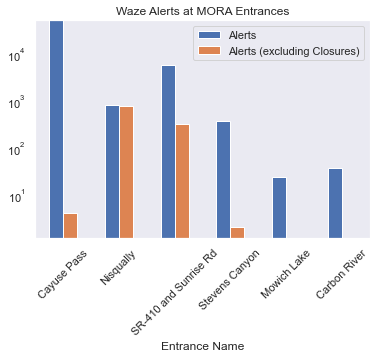

In [17]:
alertsComparison.plot.bar(x='Entrance Name', logy=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0,50000)
plt.xticks(rotation = 45)
plt.title('Waze Alerts at MORA Entrances')
plt.legend(loc = "upper right")
plt.grid(False)
plt.show()


In [18]:
#Total types of main alerts 
alerts_with_entrance.Alert.value_counts()

ROAD_CLOSED      61923
JAM               1056
WEATHERHAZARD       37
ACCIDENT             1
Name: Alert, dtype: int64

In [19]:
df_jams = alerts_with_entrance.loc[df['Alert']=='JAM']
df_jams = df_jams.reset_index()

In [20]:
df_jams_grouped=df_jams.groupby(['Name']).count()
df_jams_grouped=df_jams_grouped.reset_index()
df_jams_grouped=df_jams_grouped[['Name','Id']].sort_values(by='Name')
df_jams_grouped.rename(columns={'Id': 'Number of Jams'}, inplace=True)
df_jams_grouped

,Name,Number of Jams
0,Nisqually,746
1,SR-410 and Sunrise Rd,310


In [21]:
df_jams_type=df_jams.groupby(['Sub_Alert']).count()
df_jams_type=df_jams_type.reset_index()
df_jams_type=df_jams_type[['Sub_Alert','Id']].sort_values(by='Sub_Alert')
df_jams_type.rename(columns={'Id': 'Number of Jams'}, inplace=True)
df_jams_type

,Sub_Alert,Number of Jams
0,JAM_HEAVY_TRAFFIC,184
1,JAM_MODERATE_TRAFFIC,33
2,JAM_STAND_STILL_TRAFFIC,766


In [22]:
df_jams_pivot=df_jams.pivot_table(values='Id', index='Name', columns='Sub_Alert', aggfunc='count')
df_jams_pivot

Sub_Alert,JAM_HEAVY_TRAFFIC,JAM_MODERATE_TRAFFIC,JAM_STAND_STILL_TRAFFIC
Name,,,
Nisqually,156,23,506
SR-410 and Sunrise Rd,28,10,260


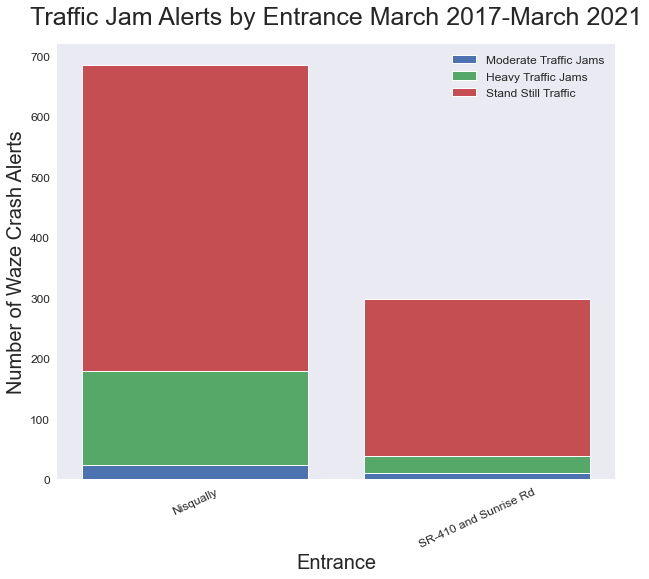

In [23]:
plt.style.use('seaborn')
tick_spacing = 1

entrances = ['Nisqually','SR-410 and Sunrise Rd']  

fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.bar(entrances,df_jams_pivot['JAM_MODERATE_TRAFFIC'], label = 'Moderate Traffic Jams', linewidth=1)
ax.bar(entrances,df_jams_pivot['JAM_HEAVY_TRAFFIC'], label = 'Heavy Traffic Jams', 
       bottom = df_jams_pivot['JAM_MODERATE_TRAFFIC'] , linewidth=1)
ax.bar(entrances,df_jams_pivot['JAM_STAND_STILL_TRAFFIC'], label = 'Stand Still Traffic', 
       bottom = df_jams_pivot['JAM_HEAVY_TRAFFIC']+df_jams_pivot['JAM_MODERATE_TRAFFIC'] , linewidth=1)

ax.set_title('Traffic Jam Alerts by Entrance March 2017-March 2021',fontsize= 25, pad = 20) # title of plot

ax.set_xlabel('Entrance',fontsize = 20) #xlabel
ax.set_ylabel('Number of Waze Crash Alerts', fontsize = 20)#ylabel
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis='x', which='major', labelsize=12,rotation = 25)
ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=6)
plt.grid(False)
plt.legend(fontsize = 12)
plt.show()

# Visitation and Waze Alerts

In [24]:
#Adding IRMA traffic counts to # alerts dataframe without closed 
d = {'Name': ['Nisqually','Stevens Canyon','Cayuse Pass','SR-410 and Sunrise Rd','Mowich Lake','Carbon River'], 
     'IRMA Counts': [1087426, 433493, 472187, 771349, 553362, 111790],
    'LBS Entrance Counts': [2295, 681, 265, 2268, 175, 28],
    'LBS Exit Counts': [2388, 771, 154, 2188, 152, 29]}
IRMA = pd.DataFrame(data=d)
IRMA


,Name,IRMA Counts,LBS Entrance Counts,LBS Exit Counts
0,Nisqually,1087426,2295,2388
1,Stevens Canyon,433493,681,771
2,Cayuse Pass,472187,265,154
3,SR-410 and Sunrise Rd,771349,2268,2188
4,Mowich Lake,553362,175,152
5,Carbon River,111790,28,29


In [25]:
df_ent_groupedNOclosed

,Name,Alerts (excluding Closures)
0,Cayuse Pass,4
1,Nisqually,772
2,SR-410 and Sunrise Rd,316
3,Stevens Canyon,2


In [26]:
d = {'Name': ['Mowich Lake','Carbon River'], 'Alerts (excluding Closures)': [0, 0]}
df2 = pd.DataFrame(data=d)
df_ent_groupedNOclosed=df_ent_groupedNOclosed.append(df2,ignore_index=True)
df_ent_groupedNOclosed

,Name,Alerts (excluding Closures)
0,Cayuse Pass,4
1,Nisqually,772
2,SR-410 and Sunrise Rd,316
3,Stevens Canyon,2
4,Mowich Lake,0
5,Carbon River,0


In [27]:
wazeIrma=df_ent_groupedNOclosed.join(IRMA.set_index('Name'), on='Name')
wazeIrma

,Name,Alerts (excluding Closures),IRMA Counts,LBS Entrance Counts,LBS Exit Counts
0,Cayuse Pass,4,472187,265,154
1,Nisqually,772,1087426,2295,2388
2,SR-410 and Sunrise Rd,316,771349,2268,2188
3,Stevens Canyon,2,433493,681,771
4,Mowich Lake,0,553362,175,152
5,Carbon River,0,111790,28,29


In [28]:
wazeIrma['WAZE %'] = (wazeIrma['Alerts (excluding Closures)'] / wazeIrma['Alerts (excluding Closures)'].sum())*100 
wazeIrma['IRMA %'] = (wazeIrma['IRMA Counts'] / wazeIrma['IRMA Counts'].sum())*100
wazeIrma['LBS Entrance %'] = (wazeIrma['LBS Entrance Counts'] / wazeIrma['LBS Entrance Counts'].sum())*100
wazeIrma['LBS Exit %'] = (wazeIrma['LBS Exit Counts'] / wazeIrma['LBS Exit Counts'].sum())*100
wazeIrma.rename(columns={'Name': 'Entrance'}, inplace=True)
wazeIrma  

,Entrance,Alerts (excluding Closures),IRMA Counts,LBS Entrance Counts,LBS Exit Counts,WAZE %,IRMA %,LBS Entrance %,LBS Exit %
0,Cayuse Pass,4,472187,265,154,0.365631,13.767962,4.639356,2.710313
1,Nisqually,772,1087426,2295,2388,70.566728,31.707015,40.178571,42.027455
2,SR-410 and Sunrise Rd,316,771349,2268,2188,28.884826,22.490886,39.705882,38.507568
3,Stevens Canyon,2,433493,681,771,0.182815,12.639728,11.922269,13.569166
4,Mowich Lake,0,553362,175,152,0.000000,16.134852,3.063725,2.675114
5,Carbon River,0,111790,28,29,0.000000,3.259557,0.490196,0.510384


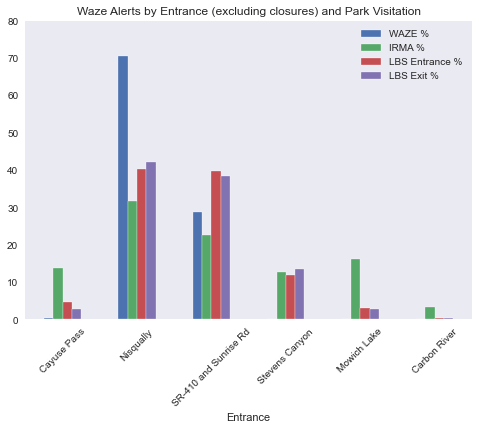

In [29]:
wazeIrma.plot.bar(x='Entrance',y=["WAZE %", "IRMA %","LBS Entrance %",'LBS Exit %'] )
plt.title('Waze Alerts by Entrance (excluding closures) and Park Visitation')
plt.ylim(0,80)
plt.xticks(rotation = 45)
plt.grid(False)
plt.legend(loc = "upper right")
plt.show()

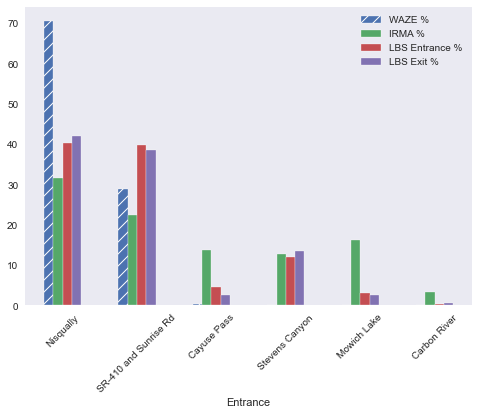

In [30]:
wazeIrma=wazeIrma.sort_values(by=['Alerts (excluding Closures)'],ascending=False)
ax = wazeIrma.plot.bar(x='Entrance',y=["WAZE %", "IRMA %","LBS Entrance %",'LBS Exit %'] )
for container, hatch in zip(ax.containers, ("//", " "," "," ")):
    for patch in container.patches:
        patch.set_hatch(hatch)
ax.legend(loc='upper right')
plt.xticks(rotation = 45)
plt.grid(False)
plt.show()

##  add total title and y axis

# Comparision to report findings

In [31]:
#opening link locations shapefile
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
links = gpd.read_file('FOTSCLBS Corresponding Polygons.kml', driver='KML')

In [32]:
#clip alerts to LBS measurement points and join 
MORAalertsLBS=gpd.clip(alertPoints,links)
alertsAlongLinks=gpd.sjoin(MORAalertsLBS,links,how="inner", op='intersects')

In [33]:
#Number of Total Alerts at Each link
linkAlerts=alertsAlongLinks.groupby(['Name']).count()
linkAlerts=linkAlerts.reset_index()
linkAlerts=linkAlerts[['Name','Id']].sort_values(by='Name')

In [34]:
#Adding FOTSC & LBS traffic counts to # alerts dataframe
d = {'Name': ['East/West Nisqually','SR 410 N of Sunrise Rd','SR 410 S of Sunrise Rd','Sunrise Rd. W of SR 410','West/East Stevens Canyon Rd. West of SR123'],
     'FOTSC Counts': [275453, 337421, 291879, 163190, 137699],
    'LBS Counts':[16641, 14844, 11013, 10399, 8056]}
flows = pd.DataFrame(data=d)
alertsAndFlows=linkAlerts.join(flows.set_index('Name'), on='Name')

In [35]:
#Calculating Percentages
alertsAndFlows['WAZE percent'] = (alertsAndFlows['Id'] / alertsAndFlows['Id'].sum()) * 100
alertsAndFlows['LBS percent'] = (alertsAndFlows['FOTSC Counts'] / alertsAndFlows['FOTSC Counts'].sum()) * 100
alertsAndFlows['FOTSC percent'] = (alertsAndFlows['LBS Counts'] / alertsAndFlows['LBS Counts'].sum()) * 100

In [36]:
# LBS calculations without road closure
#Removing Road Closure Alerts 
nonclosureAlerts = alertsAlongLinks[df.Alert != 'ROAD_CLOSED']
#Number of Total Alerts at Each LBS 
LBSnoClosed=nonclosureAlerts.groupby(['Name']).count()
LBSnoClosed=LBSnoClosed.reset_index()
LBSnoClosed=LBSnoClosed[['Name','Id']].sort_values(by='Name')
LBSnoClosed
#Adding FOTSC & LBS traffic counts to # alerts dataframe
d = {'Name': ['East/West Nisqually','SR 410 N of Sunrise Rd','SR 410 S of Sunrise Rd','Sunrise Rd. W of SR 410','West/East Stevens Canyon Rd. West of SR123'],
     'FOTSC Counts': [275453, 337421, 291879, 163190, 137699],
    'LBS Counts':[16641, 14844, 11013, 10399, 8056]}
flows = pd.DataFrame(data=d)
alertsAndFlows=LBSnoClosed.join(flows.set_index('Name'), on='Name')
#Calculating Percentages
alertsAndFlows['Waze %'] = (alertsAndFlows['Id'] / alertsAndFlows['Id'].sum()) * 100
alertsAndFlows['FOTSC %'] = (alertsAndFlows['LBS Counts'] / alertsAndFlows['LBS Counts'].sum()) * 100
alertsAndFlows['LBS %'] = (alertsAndFlows['FOTSC Counts'] / alertsAndFlows['FOTSC Counts'].sum()) * 100
alertsAndFlows.rename(columns={'alert_char_crc': 'Waze Alerts Count'}, inplace=True)
alertsAndFlows.rename(columns={'Name': 'Location'}, inplace=True)
alertsAndFlows

,Location,Id,FOTSC Counts,LBS Counts,Waze %,FOTSC %,LBS %
0,East/West Nisqually,774,275453,16641,71.402214,27.301363,22.846998
1,SR 410 N of Sunrise Rd,18,337421,14844,1.660517,24.353190,27.986832
2,SR 410 S of Sunrise Rd,12,291879,11013,1.107011,18.068020,24.209425
3,Sunrise Rd. W of SR 410,278,163190,10399,25.645756,17.060686,13.535527
4,West/East Stevens Canyon Rd. West of SR123,2,137699,8056,0.184502,13.216741,11.421218


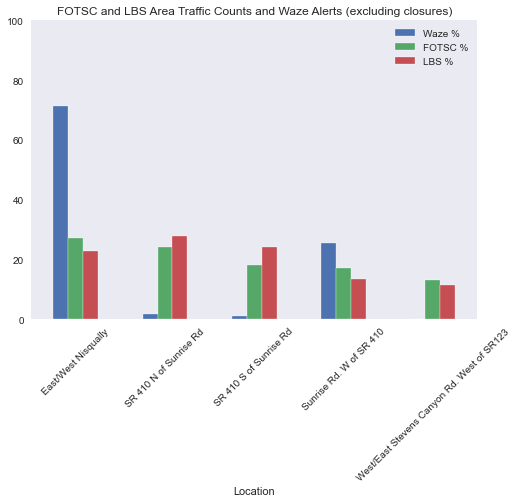

In [37]:
alertsAndFlows.plot.bar(x='Location',y=["Waze %", "FOTSC %", 'LBS %'] )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0,100)
plt.xticks(rotation = 45)
plt.title('FOTSC and LBS Area Traffic Counts and Waze Alerts (excluding closures)')
plt.grid(False)
plt.legend(loc = "upper right")
plt.show()

# Full Park Analysis

In [10]:
#working with full park shape 
#gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
outline = gpd.read_file('NPS_-_Land_Resources_Division_Boundary_and_Tract_Data_Service.shp')

#MORAparkAlerts.to_csv('park.csv')

In [24]:
outline.head()

,OBJECTID,UNIT_CODE,GIS_Notes,UNIT_NAME,DATE_EDIT,STATE,REGION,GNIS_ID,UNIT_TYPE,CREATED_BY,METADATA,PARKNAME,CreationDa,Creator,EditDate,Editor,Shape__Are,Shape__Len,GlobalID,geometry
0,1,AMME,PRELIMINARY - Data has not completed the entir...,American Memorial Park,2015-04-22,MP,PW,1879026,Park,Lands,Preliminary data. Contact the Land Resources P...,American Memorial Park,2020-01-09,SCarlton@nps.gov_nps,2020-01-09,SCarlton@nps.gov_nps,6.113585e+05,7740.973865,79037b52-9d9c-4f8c-b65b-70b810814fb0,"POLYGON ((16221864.905 1714852.206, 16221867.9..."
1,2,CEBE,Lands - http://landsnet.nps.gov/tractsnet/docu...,Cedar Creek and Belle Grove National Historica...,2005-04-07,VA,NE,1985663,National Historical Park,Lands,https://irma.nps.gov/DataStore/Reference/Profi...,Cedar Creek & Belle Grove,2020-01-09,SCarlton@nps.gov_nps,2020-06-04,RJohnson@nps.gov_nps,2.328283e+07,53250.857647,dfdc7906-209d-42e5-95e8-5a0377ca9b06,"MULTIPOLYGON (((-8715759.414 4724026.776, -871..."
2,3,LIBI,Lands - http://landsnet.nps.gov/tractsnet/docu...,Little Bighorn Battlefield National Monument,2005-02-23,MT,IM,806297,National Monument,Lands,https://irma.nps.gov/DataStore/Reference/Profi...,Little Bighorn Battlefield,2020-01-09,SCarlton@nps.gov_nps,2020-06-04,RJohnson@nps.gov_nps,6.437513e+06,19524.580108,a3affc26-f98a-417d-aa5b-41cfb4988cc8,"MULTIPOLYGON (((-11953415.314 5703937.476, -11..."
3,4,CAVO,Lands - http://landsnet.nps.gov/tractsnet/docu...,Capulin Volcano National Monument,2004-07-22,NM,IM,936867,National Monument,Lands,https://irma.nps.gov/DataStore/Reference/Profi...,Capulin Volcano,2020-01-09,SCarlton@nps.gov_nps,2020-06-04,RJohnson@nps.gov_nps,4.997144e+06,10529.570772,646548c2-c5b8-4298-a6b2-a82b5977581e,"POLYGON ((-11575101.835 4409222.280, -11574603..."
4,5,FOBO,Lands - http://landsnet.nps.gov/tractsnet/docu...,Fort Bowie National Historic Site,2004-05-12,AZ,IM,1888916,National Historic Site,Lands,https://irma.nps.gov/DataStore/Reference/Profi...,Fort Bowie,2020-01-09,SCarlton@nps.gov_nps,2020-06-04,RJohnson@nps.gov_nps,5.650399e+06,18638.556950,a19874b5-9d2e-409b-ba2a-8b52f4649602,"POLYGON ((-12187153.674 3783174.666, -12187626..."


In [11]:
MORAoutline= outline.loc[outline['UNIT_CODE']=='MORA']
MORAoutline=MORAoutline.to_crs(epsg=4326)

In [36]:
alertPoints

,Id,NAME,UNIT_TYPE,Time,Alert,Sub_Alert,Street,State,Lon,Lat,Type,geometry
0,1,MORA,National Park,2017-03-05 12:54:05,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.539917,46.866887,in-park,POINT (-121.53992 46.86689)
1,2,MORA,National Park,2017-03-05 12:54:06,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.520425,46.869337,in-park,POINT (-121.52043 46.86934)
2,3,MORA,National Park,2017-03-05 12:53:46,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-123,WA,-121.519142,46.830834,in-park,POINT (-121.51914 46.83083)
3,4,MORA,National Park,2017-03-05 12:54:33,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-123,WA,-121.554361,46.785824,in-park,POINT (-121.55436 46.78582)
4,5,MORA,National Park,2017-03-05 12:53:40,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-123,WA,-121.554361,46.785824,in-park,POINT (-121.55436 46.78582)
...,...,...,...,...,...,...,...,...,...,...,...,...
309586,309587,MORA,National Park,2021-08-15 22:34:45,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,US-12,WA,-121.709705,46.566126,region,POINT (-121.70970 46.56613)
309587,309588,MORA,National Park,2021-08-16 23:22:34,JAM,JAM_STAND_STILL_TRAFFIC,SR-410,WA,-122.013015,47.180126,region,POINT (-122.01301 47.18013)
309588,309589,MORA,National Park,2021-08-16 23:47:27,JAM,JAM_MODERATE_TRAFFIC,SR-410 E,WA,-122.199203,47.184778,region,POINT (-122.19920 47.18478)
309589,309590,MORA,National Park,2021-08-16 23:47:27,JAM,JAM_MODERATE_TRAFFIC,SR-410 E,WA,-122.199203,47.184778,region,POINT (-122.19920 47.18478)


In [12]:
MORAparkAlerts=gpd.clip(alertPoints,MORAoutline)
MORAparkAlerts

,Id,NAME,UNIT_TYPE,Time,Alert,Sub_Alert,Street,State,Lon,Lat,Type,geometry
0,1,MORA,National Park,2017-03-05 12:54:05,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.539917,46.866887,in-park,POINT (-121.53992 46.86689)
1,2,MORA,National Park,2017-03-05 12:54:06,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.520425,46.869337,in-park,POINT (-121.52043 46.86934)
2,3,MORA,National Park,2017-03-05 12:53:46,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-123,WA,-121.519142,46.830834,in-park,POINT (-121.51914 46.83083)
3,4,MORA,National Park,2017-03-05 12:54:33,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-123,WA,-121.554361,46.785824,in-park,POINT (-121.55436 46.78582)
4,5,MORA,National Park,2017-03-05 12:53:40,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-123,WA,-121.554361,46.785824,in-park,POINT (-121.55436 46.78582)
...,...,...,...,...,...,...,...,...,...,...,...,...
309072,309073,MORA,National Park,2021-08-05 00:01:05,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,SR-706,WA,-122.119272,46.754440,region,POINT (-122.11927 46.75444)
309131,309132,MORA,National Park,2021-07-26 18:48:36,JAM,JAM_HEAVY_TRAFFIC,Mount Rainier National Park: Nisqually Entrance,WA,-121.917828,46.741094,region,POINT (-121.91783 46.74109)
309252,309253,MORA,National Park,2021-07-07 18:09:16,JAM,JAM_STAND_STILL_TRAFFIC,Mount Rainier National Park: Nisqually Entrance,WA,-121.917502,46.741061,region,POINT (-121.91750 46.74106)
309397,309398,MORA,National Park,2021-06-25 16:46:02,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,SR-706,WA,-122.124522,46.755054,region,POINT (-122.12452 46.75505)


In [13]:
#working with region shape 
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
region = gpd.read_file('MORA Region.kml', driver='KML')
MORAAlerts=gpd.clip(alertPoints,region)
#MORAAlerts.to_csv('region.csv')

In [40]:
def label_season(row):
    if row['Time'].month in [1,2,3,4,11,12] or (row['Time'].month==5 and row['Time'].day<=15):
        return('Winter')
    elif row['Time'].month in [6] or (row['Time'].month==5 and row['Time'].day>15) or (row['Time'].month==10 and row['Time'].day<15):
        return('Shoulder')
    return('Peak')

In [41]:
MORAparkAlerts['Time']=pd.to_datetime(df['Time'])

In [42]:
MORAparkAlerts['season']=MORAparkAlerts.apply(lambda row:label_season(row), axis=1)
df_season_grouped=MORAparkAlerts.groupby(['season']).count()
df_season_grouped=df_season_grouped.reset_index()
df_season_grouped=df_season_grouped[['season','Id']].sort_values(by='season')

In [43]:
MORAparkAlerts['day_of_week'] = MORAparkAlerts['Time'].dt.day_name()
df_day_grouped=MORAparkAlerts.groupby(['day_of_week']).count()
df_day_grouped=df_day_grouped.reset_index()
df_day_grouped=df_day_grouped[['day_of_week','Id']].sort_values(by='day_of_week')
df_day_grouped=df_day_grouped.reindex([1,5,6,4,0,2,3])
df_day_grouped

,day_of_week,Id
1,Monday,7408
5,Tuesday,8808
6,Wednesday,7372
4,Thursday,7576
0,Friday,7522
2,Saturday,7308
3,Sunday,7806


In [44]:
nonclosureAlertsPark = MORAparkAlerts.loc[df['Alert']!='ROAD_CLOSED']

In [45]:
#day of the week without closed alerts 
df_day_groupedNOclosed=nonclosureAlertsPark.groupby(['day_of_week']).count()
df_day_groupedNOclosed=df_day_groupedNOclosed.reset_index()
df_day_groupedNOclosed=df_day_groupedNOclosed[['day_of_week','Id']].sort_values(by='day_of_week')
df_day_groupedNOclosed=df_day_groupedNOclosed.reindex([1,5,6,4,0,2,3])
df_day_groupedNOclosed

,day_of_week,Id
1,Monday,20
5,Tuesday,10
6,Wednesday,28
4,Thursday,30
0,Friday,20
2,Saturday,108
3,Sunday,94


In [46]:
df_day_groupedNOclosed['Alerts (including closures)']=df_day_grouped['Id']
df_day_groupedNOclosed.rename(columns={'Id': 'Alerts (excluding closures)'}, inplace=True)
df_day_groupedNOclosed

,day_of_week,Alerts (excluding closures),Alerts (including closures)
1,Monday,20,7408
5,Tuesday,10,8808
6,Wednesday,28,7372
4,Thursday,30,7576
0,Friday,20,7522
2,Saturday,108,7308
3,Sunday,94,7806


In [47]:
#removing closures and doing weekday and seasonal analysis 
df_season_groupedNOclosed=nonclosureAlertsPark.groupby(['season']).count()
df_season_groupedNOclosed=df_season_groupedNOclosed.reset_index()
df_season_groupedNOclosed=df_season_groupedNOclosed[['season','Id']].sort_values(by='season')

In [48]:
df_season_groupedNOclosed['Including Closure']=df_season_grouped['Id']
df_season_groupedNOclosed.rename(columns={'Id': 'Alerts (excluding closures)'})

,season,Alerts (excluding closures),Including Closure
0,Peak,272,830
1,Shoulder,36,4312
2,Winter,2,48658


In [49]:
MORAparkAlerts['Hour'] = MORAparkAlerts['Time'].dt.hour
df_time_groupedC=MORAparkAlerts.groupby(['Hour']).count()
df_time_groupedC=df_time_groupedC.reset_index()
df_time_groupedC=df_time_groupedC[['Hour','Id']].sort_values(by='Hour')

In [50]:
nonclosureAlertsPark['Hour'] = nonclosureAlertsPark['Time'].dt.hour
df_time_grouped=nonclosureAlertsPark.groupby(['Hour']).count()
df_time_grouped=df_time_grouped.reset_index()
df_time_grouped=df_time_grouped[['Hour','Id']].sort_values(by='Hour')

In [51]:
all_hours = pd.Series(data = range(1 , 24))
missing_hours = all_hours[~all_hours.isin(df_time_grouped.Hour)]
missing_df = pd.DataFrame({'Hour' : missing_hours.values , 'Id' : 0})
hourly_df=pd.concat([df_time_grouped , missing_df])
hourly_sorted=hourly_df.sort_values('Hour')
hourly_sorted_df=hourly_sorted.reset_index(drop=True)
hourly_sorted_df['Alerts (including closures)']=df_time_groupedC['Id']
hourly_sorted_df.rename(columns={'Id': 'Alerts (excluding closures)'}, inplace=True)
hourly_sorted_df

,Hour,Alerts (excluding closures),Alerts (including closures)
0,0,10,2128
1,1,4,1970
2,2,2,1986
3,3,0,1918
4,4,2,1908
5,5,0,1840
6,6,0,5950
7,7,0,2042
8,8,0,2220
9,9,0,1952


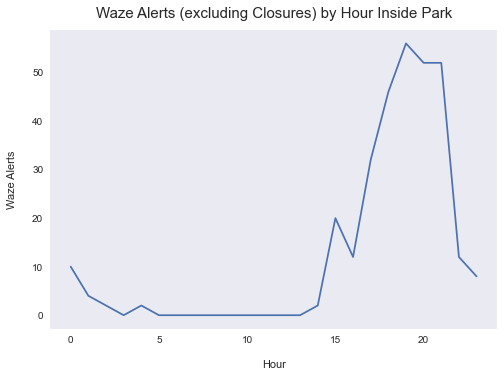

In [52]:
plt.style.use('seaborn')
plt.plot( 'Hour', 'Alerts (excluding closures)', data=hourly_sorted_df)
plt.xlabel("Hour", labelpad=15)
plt.ylabel("Waze Alerts", labelpad=15)
plt.title("Waze Alerts (excluding Closures) by Hour Inside Park", y=1.02, fontsize=15)
plt.grid(False)
plt.show()

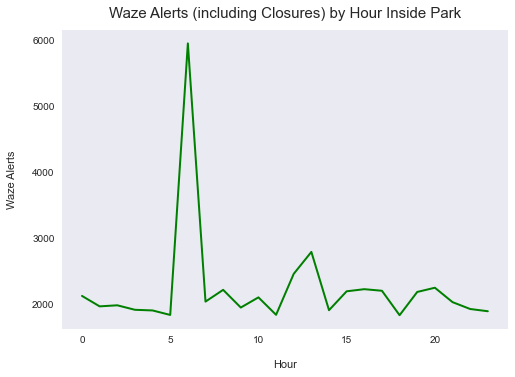

In [53]:
plt.style.use('seaborn')
plt.plot( 'Hour', 'Alerts (including closures)', data=hourly_sorted_df, marker='', color='green', linewidth=2)
plt.xlabel("Hour", labelpad=15)
plt.ylabel("Waze Alerts", labelpad=15)
plt.title("Waze Alerts (including Closures) by Hour Inside Park", y=1.02, fontsize=15)
plt.grid(False)
plt.show()

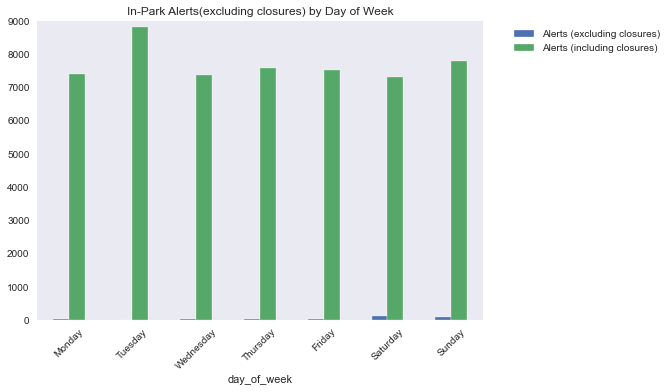

In [54]:
df_day_groupedNOclosed.plot.bar(x='day_of_week',y=["Alerts (excluding closures)", "Alerts (including closures)"] )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0,9000)
plt.xticks(rotation = 45)
plt.title('In-Park Alerts(excluding closures) by Day of Week')
plt.grid(False)
plt.show()

In [55]:
df_day_pivot=MORAparkAlerts.pivot_table(values='Id', index='day_of_week', columns='Alert', aggfunc='count')
df_day_pivot.fillna(0, inplace=True)
df_day_pivot=df_day_pivot.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ])
df_day_pivot

Alert,ACCIDENT,JAM,ROAD_CLOSED,WEATHERHAZARD
day_of_week,,,,
Monday,0.0,18.0,7388.0,2.0
Tuesday,0.0,8.0,8798.0,2.0
Wednesday,0.0,12.0,7344.0,16.0
Thursday,0.0,10.0,7546.0,20.0
Friday,2.0,12.0,7502.0,6.0
Saturday,0.0,96.0,7200.0,12.0
Sunday,0.0,86.0,7712.0,8.0


In [56]:
park_jams= MORAparkAlerts.loc[df['Alert']=='JAM']
park_jams = park_jams.reset_index()
df_day_jam=park_jams.pivot_table(values='Id',index='day_of_week',columns='Sub_Alert',aggfunc='count')
df_day_jam.fillna(0, inplace=True)
df_day_jam=df_day_jam.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
df_day_jam

Sub_Alert,JAM_HEAVY_TRAFFIC,JAM_MODERATE_TRAFFIC,JAM_STAND_STILL_TRAFFIC
day_of_week,,,
Monday,2.0,0.0,16.0
Tuesday,0.0,2.0,4.0
Wednesday,0.0,2.0,8.0
Thursday,0.0,0.0,8.0
Friday,4.0,2.0,6.0
Saturday,6.0,0.0,86.0
Sunday,12.0,2.0,68.0


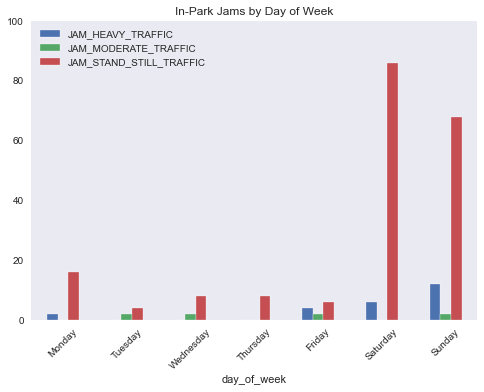

In [57]:
df_day_jam.plot.bar()
plt.legend(loc='upper left')
plt.ylim(0,100)
plt.xticks(rotation = 45)
plt.title('In-Park Jams by Day of Week')
plt.grid(False)
plt.show()

In [58]:
df_time_pivot=nonclosureAlertsPark.pivot_table(values='Id', index='Hour', columns='Sub_Alert', aggfunc='count')
df_time_pivot.fillna(0, inplace=True)
df_time_pivot

Sub_Alert,ACCIDENT_MINOR,HAZARD_ON_ROAD_CAR_STOPPED,HAZARD_ON_ROAD_CONSTRUCTION,HAZARD_ON_ROAD_OBJECT,HAZARD_ON_ROAD_POT_HOLE,HAZARD_ON_SHOULDER_ANIMALS,HAZARD_ON_SHOULDER_CAR_STOPPED,JAM_HEAVY_TRAFFIC,JAM_MODERATE_TRAFFIC,JAM_STAND_STILL_TRAFFIC
Hour,,,,,,,,,,
0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
14,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,14.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,6.0
17,0.0,0.0,4.0,0.0,0.0,0.0,2.0,4.0,2.0,16.0
18,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,2.0,32.0


In [59]:
MORAparkSSJams=MORAparkAlerts.loc[MORAparkAlerts['Sub_Alert']=='JAM_STAND_STILL_TRAFFIC']
MORAparkSSJams

,Id,NAME,UNIT_TYPE,Time,Alert,Sub_Alert,Street,State,Lon,Lat,Type,geometry,season,day_of_week,Hour
236,237,MORA,National Park,2017-07-03 21:37:32,JAM,JAM_STAND_STILL_TRAFFIC,Sunrise Park Rd,WA,-121.551221,46.903165,in-park,POINT (-121.55122 46.90317),Peak,Monday,21
237,238,MORA,National Park,2017-07-02 20:26:35,JAM,JAM_STAND_STILL_TRAFFIC,Sunrise Park Rd,WA,-121.548984,46.904061,in-park,POINT (-121.54898 46.90406),Peak,Sunday,20
238,239,MORA,National Park,2017-07-03 18:03:16,JAM,JAM_STAND_STILL_TRAFFIC,Sunrise Park Rd,WA,-121.550132,46.903573,in-park,POINT (-121.55013 46.90357),Peak,Monday,18
240,241,MORA,National Park,2017-08-20 19:52:26,JAM,JAM_STAND_STILL_TRAFFIC,Sunrise Park Rd,WA,-121.550613,46.903392,in-park,POINT (-121.55061 46.90339),Peak,Sunday,19
241,242,MORA,National Park,2017-08-20 19:52:26,JAM,JAM_STAND_STILL_TRAFFIC,Sunrise Park Rd,WA,-121.552083,46.902842,in-park,POINT (-121.55208 46.90284),Peak,Sunday,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289325,289326,MORA,National Park,2021-07-05 20:27:12,JAM,JAM_STAND_STILL_TRAFFIC,White River Rd,WA,-121.548787,46.904150,region,POINT (-121.54879 46.90415),Peak,Monday,20
298749,298750,MORA,National Park,2021-08-12 19:18:57,JAM,JAM_STAND_STILL_TRAFFIC,Stevens Canyon Rd,WA,-121.666085,46.763980,region,POINT (-121.66608 46.76398),Peak,Thursday,19
308218,308219,MORA,National Park,2021-07-22 19:31:15,JAM,JAM_STAND_STILL_TRAFFIC,White River Rd,WA,-121.554043,46.902133,region,POINT (-121.55404 46.90213),Peak,Thursday,19
308372,308373,MORA,National Park,2021-07-24 20:06:23,JAM,JAM_STAND_STILL_TRAFFIC,Stevens Canyon Rd,WA,-121.657095,46.761724,region,POINT (-121.65709 46.76172),Peak,Saturday,20


In [60]:
MORAparkSSJamsGrouped=MORAparkSSJams.groupby(['Street','Hour']).count()
MORAparkSSJamsGrouped=MORAparkSSJamsGrouped.reset_index()
MORAparkSSJamsGrouped=MORAparkSSJamsGrouped[['Hour','Street','Id']].sort_values(by='Street')
MORAparkSSJamsGrouped.rename(columns={'Id': 'Alerts'}, inplace=True)
MORAparkSSJamsGrouped

,Hour,Street,Alerts
0,22,Longmire to Paradise,2
1,1,SR-410,2
2,15,SR-410,2
3,17,SR-410,4
4,20,SR-410,2
5,21,SR-410,4
6,19,Stevens Canyon Rd,2
7,20,Stevens Canyon Rd,2
14,21,Sunrise Park Rd,18
13,20,Sunrise Park Rd,16


In [61]:
LongmiretoParadise=MORAparkSSJamsGrouped.loc[MORAparkSSJamsGrouped['Street']=='Longmire to Paradise']
SR410=MORAparkSSJamsGrouped.loc[MORAparkSSJamsGrouped['Street']=='SR-410']
StevensCanyonRd=MORAparkSSJamsGrouped.loc[MORAparkSSJamsGrouped['Street']=='Stevens Canyon Rd']
SunriseParkRd	=MORAparkSSJamsGrouped.loc[MORAparkSSJamsGrouped['Street']=='Sunrise Park Rd']
SunriseRd=MORAparkSSJamsGrouped.loc[MORAparkSSJamsGrouped['Street']=='Sunrise Rd']
WhiteRiverRd=MORAparkSSJamsGrouped.loc[MORAparkSSJamsGrouped['Street']=='White River Rd']

In [62]:
all_hours = pd.Series(data = range(1 , 24))
missing_hours = all_hours[~all_hours.isin(LongmiretoParadise.Hour)]
missing_df = pd.DataFrame({'Hour' : missing_hours.values , 'Street':'Longmire to Paradise', 'Alerts' : 0})
hourly_df=pd.concat([LongmiretoParadise , missing_df])
hourly_sorted=hourly_df.sort_values('Hour')
hourly_sorted_dfLMP=hourly_sorted.reset_index(drop=True)

In [63]:
all_hours = pd.Series(data = range(1 , 24))
missing_hours = all_hours[~all_hours.isin(SR410.Hour)]
missing_df = pd.DataFrame({'Hour' : missing_hours.values , 'Street':'SR-410', 'Alerts' : 0})
hourly_df=pd.concat([SR410 , missing_df])
hourly_sorted=hourly_df.sort_values('Hour')
hourly_sorted_dfSR410=hourly_sorted.reset_index(drop=True)

In [64]:
all_hours = pd.Series(data = range(1 , 24))
missing_hours = all_hours[~all_hours.isin(StevensCanyonRd.Hour)]
missing_df = pd.DataFrame({'Hour' : missing_hours.values , 'Street':'Stevens Canyon Rd', 'Alerts' : 0})
hourly_df=pd.concat([StevensCanyonRd , missing_df])
hourly_sorted=hourly_df.sort_values('Hour')
hourly_sorted_dfSCR=hourly_sorted.reset_index(drop=True)

In [65]:
all_hours = pd.Series(data = range(1 , 24))
missing_hours = all_hours[~all_hours.isin(SunriseParkRd.Hour)]
missing_df = pd.DataFrame({'Hour' : missing_hours.values , 'Street':'Sunrise Park Rd', 'Alerts' : 0})
hourly_df=pd.concat([SunriseParkRd , missing_df])
hourly_sorted=hourly_df.sort_values('Hour')
hourly_sorted_dfSPR=hourly_sorted.reset_index(drop=True)

In [66]:
all_hours = pd.Series(data = range(1 , 24))
missing_hours = all_hours[~all_hours.isin(SunriseRd.Hour)]
missing_df = pd.DataFrame({'Hour' : missing_hours.values , 'Street':'Sunrise Rd', 'Alerts' : 0})
hourly_df=pd.concat([SunriseRd , missing_df])
hourly_sorted=hourly_df.sort_values('Hour')
hourly_sorted_dfSR=hourly_sorted.reset_index(drop=True)

In [67]:
all_hours = pd.Series(data = range(1 , 24))
missing_hours = all_hours[~all_hours.isin(WhiteRiverRd.Hour)]
missing_df = pd.DataFrame({'Hour' : missing_hours.values , 'Street':'WhiteRiverRd', 'Alerts' : 0})
hourly_df=pd.concat([WhiteRiverRd , missing_df])
hourly_sorted=hourly_df.sort_values('Hour')
hourly_sorted_dfWRR=hourly_sorted.reset_index(drop=True)

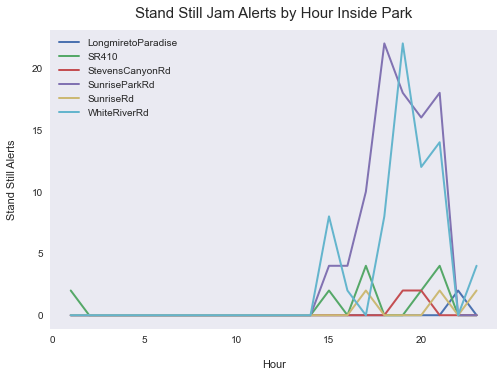

In [68]:
# LongmiretoParadise=hourly_sorted_dfLMP.plot.line(x='Hour', y='Alerts')
# SR410=hourly_sorted_dfSR410.plot.line(x='Hour', y='Alerts')

# StevensCanyon
# SunriseParkRd
# SunriseRd
# WhiteRiverRd  


plt.style.use('seaborn')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_dfLMP, marker='',  linewidth=2, label='LongmiretoParadise')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_dfSR410, marker='', linewidth=2,label='SR410')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_dfSCR, marker='', linewidth=2,label='StevensCanyonRd')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_dfSPR, marker='', linewidth=2,label='SunriseParkRd')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_dfSR, marker='', linewidth=2,label='SunriseRd')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_dfWRR, marker='', linewidth=2,label='WhiteRiverRd')

plt.xlabel("Hour", labelpad=15)
plt.ylabel("Stand Still Alerts", labelpad=15)
plt.title("Stand Still Jam Alerts by Hour Inside Park", y=1.02, fontsize=15)
plt.grid(False)
plt.legend(loc = "upper left")
plt.show()

In [69]:
MORAparkSSJamsGroupedTime=MORAparkSSJams.groupby(['Hour']).count()
MORAparkSSJamsGroupedTime=MORAparkSSJamsGroupedTime.reset_index()
MORAparkSSJamsGroupedTime=MORAparkSSJamsGroupedTime[['Hour','Id']].sort_values(by='Hour')
MORAparkSSJamsGroupedTime.rename(columns={'Id': 'Alerts'}, inplace=True)
MORAparkSSJamsGroupedTime

,Hour,Alerts
0,0,2
1,1,2
2,15,14
3,16,6
4,17,16
5,18,32
6,19,42
7,20,32
8,21,40
9,22,4


In [70]:
all_hours = pd.Series(data = range(1 , 24))
missing_hours = all_hours[~all_hours.isin(MORAparkSSJamsGroupedTime.Hour)]
missing_df = pd.DataFrame({'Hour' : missing_hours.values , 'Alerts' : 0})
hourly_df=pd.concat([MORAparkSSJamsGroupedTime , missing_df])
hourly_sorted=hourly_df.sort_values('Hour')
hourly_sorted_df=hourly_sorted.reset_index(drop=True)
hourly_sorted_df

,Hour,Alerts
0,0,2
1,1,2
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


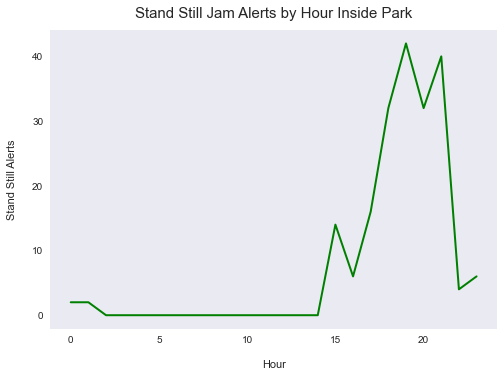

In [71]:
plt.style.use('seaborn')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_df, marker='', color='green', linewidth=2)
plt.xlabel("Hour", labelpad=15)
plt.ylabel("Stand Still Alerts", labelpad=15)
plt.title("Stand Still Jam Alerts by Hour Inside Park", y=1.02, fontsize=15)
plt.grid(False)
plt.show()

In [72]:
nonclosureAlerts['Time']=pd.to_datetime(nonclosureAlerts['Time'])
nonclosureAlerts['Hour'] = nonclosureAlerts['Time'].dt.hour
MORAentSSJams=nonclosureAlerts.loc[nonclosureAlerts['Sub_Alert']=='JAM_STAND_STILL_TRAFFIC']
MORAentSSJamsGrouped=MORAentSSJams.groupby(['Name','Hour']).count()
MORAentSSJamsGrouped=MORAentSSJamsGrouped.reset_index()
MORAentSSJamsGrouped=MORAentSSJamsGrouped[['Hour','Name','Id']].sort_values(by='Name')
MORAentSSJamsGrouped.rename(columns={'Id': 'Alerts'}, inplace=True)
Nisqually=MORAentSSJamsGrouped.loc[MORAentSSJamsGrouped['Name']=='Nisqually']
SR410Sunrise=MORAentSSJamsGrouped.loc[MORAentSSJamsGrouped['Name']=='SR-410 and Sunrise Rd']

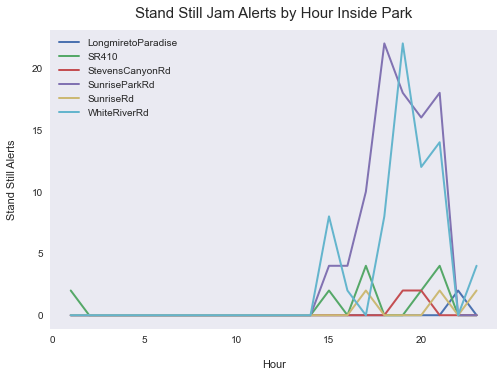

In [73]:
plt.style.use('seaborn')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_dfLMP, marker='',  linewidth=2, label='LongmiretoParadise')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_dfSR410, marker='', linewidth=2,label='SR410')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_dfSCR, marker='', linewidth=2,label='StevensCanyonRd')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_dfSPR, marker='', linewidth=2,label='SunriseParkRd')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_dfSR, marker='', linewidth=2,label='SunriseRd')
plt.plot( 'Hour', 'Alerts', data=hourly_sorted_dfWRR, marker='', linewidth=2,label='WhiteRiverRd')

plt.xlabel("Hour", labelpad=15)
plt.ylabel("Stand Still Alerts", labelpad=15)
plt.title("Stand Still Jam Alerts by Hour Inside Park", y=1.02, fontsize=15)
plt.grid(False)
plt.legend(loc = "upper left")
plt.show()

In [84]:
alerts_with_entrance.columns

Index(['Id', 'NAME', 'UNIT_TYPE', 'Time', 'Alert', 'Sub_Alert', 'Street',
       'State', 'Lon', 'Lat', 'Type', 'geometry', 'index_right', 'Name',
       'Description'],
      dtype='object')

In [14]:
alerts_with_entrance.drop(columns=['index_right', 'Description'], inplace=True)
alerts_with_entrance.rename(columns={'Name': 'Entrance'}, inplace=True)

In [96]:
alerts_with_entrance.columns

Index(['Id', 'NAME', 'UNIT_TYPE', 'Time', 'Alert', 'Sub_Alert', 'Street',
       'State', 'Lon', 'Lat', 'Type', 'geometry', 'Entrance', 'Park',
       'Region'],
      dtype='object')

In [15]:
alerts_with_entrance['Park']=0
alerts_with_entrance['Region']=0
MORAparkAlerts['Park']=1
MORAparkAlerts['Region']=0
MORAAlerts['Park']=0
MORAAlerts['Region']=1

In [28]:
MORAparkAlerts.columns

Index(['Id', 'NAME', 'UNIT_TYPE', 'Time', 'Alert', 'Sub_Alert', 'Street',
       'State', 'Lon', 'Lat', 'Type', 'geometry', 'Park', 'Region'],
      dtype='object')

In [95]:
MORAAlerts.columns

Index(['Id', 'NAME', 'UNIT_TYPE', 'Time', 'Alert', 'Sub_Alert', 'Street',
       'State', 'Lon', 'Lat', 'Type', 'geometry', 'Park', 'Region'],
      dtype='object')

In [40]:
entPark=pd.concat([alerts_with_entrance, MORAparkAlerts], ignore_index=True)

In [41]:
allAlerts=pd.concat([entPark, MORAAlerts], ignore_index=True)

In [42]:
alerts=allAlerts.drop_duplicates(subset=['Id'])
#alerts.to_csv('MORAalertsTotal.csv')

In [23]:
total = alerts['Region'].sum()
print(total)

77756


In [24]:
total = alerts['Park'].sum()
print(total)

81438


In [45]:
alerts.count()

Id           159194
NAME         159194
UNIT_TYPE    159194
Time         159194
Alert        159194
Sub_Alert    156682
Street       158557
State        159194
Lon          159194
Lat          159194
Type         159194
geometry     159194
Entrance      89735
Park         159194
Region       159194
dtype: int64

In [16]:
allAlerts=pd.concat([MORAparkAlerts, MORAAlerts], ignore_index=True)
alerts=allAlerts.drop_duplicates(subset=['Id'])

In [22]:
alerts.count()

Id           159194
NAME         159194
UNIT_TYPE    159194
Time         159194
Alert        159194
Sub_Alert    156682
Street       158557
State        159194
Lon          159194
Lat          159194
Type         159194
geometry     159194
Park         159194
Region       159194
dtype: int64

In [18]:
alerts_with_entrance=gpd.sjoin(alerts,entrances,how="inner", op='intersects')
alerts_with_entrance

,Id,NAME,UNIT_TYPE,Time,Alert,Sub_Alert,Street,State,Lon,Lat,Type,geometry,Park,Region,index_right,Name,Description
1,2,MORA,National Park,2017-03-05 12:54:06,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.520425,46.869337,in-park,POINT (-121.52043 46.86934),1,0,2,Cayuse Pass,
47,48,MORA,National Park,2017-05-06 17:46:57,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.520425,46.869337,in-park,POINT (-121.52043 46.86934),1,0,2,Cayuse Pass,
96,97,MORA,National Park,2017-05-21 02:11:07,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.520425,46.869337,in-park,POINT (-121.52043 46.86934),1,0,2,Cayuse Pass,
103,104,MORA,National Park,2017-04-05 19:36:06,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.520425,46.869337,in-park,POINT (-121.52043 46.86934),1,0,2,Cayuse Pass,
120,121,MORA,National Park,2017-05-21 02:11:04,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-410,WA,-121.520425,46.869337,in-park,POINT (-121.52043 46.86934),1,0,2,Cayuse Pass,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158423,202332,MORA,National Park,2020-04-14 06:27:19,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-165,WA,-121.926813,46.931289,region,POINT (-121.92681 46.93129),0,1,4,Mowich Lake,
159457,207011,MORA,National Park,2020-10-23 16:28:52,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-165,WA,-121.972483,46.943016,region,POINT (-121.97248 46.94302),0,1,4,Mowich Lake,
159459,207013,MORA,National Park,2020-10-23 16:28:53,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-165,WA,-121.945731,46.934988,region,POINT (-121.94573 46.93499),0,1,4,Mowich Lake,
159485,207105,MORA,National Park,2020-10-23 16:28:53,ROAD_CLOSED,ROAD_CLOSED_EVENT,SR-165,WA,-121.978854,46.948086,region,POINT (-121.97885 46.94809),0,1,4,Mowich Lake,


In [20]:
alerts_with_entrance.drop(columns=['index_right', 'Description'], inplace=True)
alerts_with_entrance.rename(columns={'Name': 'Entrance'}, inplace=True)

In [21]:
alerts_with_entrance.count()

Id           89735
NAME         89735
UNIT_TYPE    89735
Time         89735
Alert        89735
Sub_Alert    89628
Street       89702
State        89735
Lon          89735
Lat          89735
Type         89735
geometry     89735
Park         89735
Region       89735
Entrance     89735
dtype: int64